#### In this notebook we are going to create a simple backtesting strategy where we have 3 differentt predictions for each day: "Buy", "Sell" and "Close". If "Buy", we buy one share, if "Hold" we do nothing and if "Sell" we sell all the options we have previously bought.

First of all, we have to load our data. We are going to get it from YahooFinance

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
from pandas_datareader import data as pdr

def load_data(stock_name, start_date, end_date = []):
    
    yf.pdr_override()
    
    # Start date:
    start_year, start_month, start_day = start_date
    start = dt.datetime(start_year,start_month,start_day)
    
    # End date
    if end_date: # If no data is passed to end_date, we assume it is now 
        end_year, end_month, end_day = end_date
        end = dt.datetime(end_year,end_month,end_day)
    else:
        end = dt.datetime.now()

    df=pdr.get_data_yahoo(stock_name,start,end)
    
    # To change index from date to num:
    df = df.reset_index()
    
    return df
    
load_data("AAPL",[2022,1,1]).head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,177.830002,182.880005,177.710007,182.009995,179.481125,104487900
1,2022-01-04,182.630005,182.940002,179.119995,179.699997,177.203201,99310400
2,2022-01-05,179.610001,180.169998,174.639999,174.919998,172.489624,94537600
3,2022-01-06,172.699997,175.300003,171.639999,172.000000,169.610214,96904000
4,2022-01-07,172.889999,174.139999,171.029999,172.169998,169.777832,86709100


Now, we are going to generate a sample data for the predictions in the time range selected:

In [24]:
import random

def sample_predictions_array(data):
    # random.seed(1)
    sample_predictions_df = pd.DataFrame(columns=["Date","Prediction"])
    for value in data.iterrows():
        date = value[1][0]    
        
        rand_num = random.uniform(0,1)
        if 0 < rand_num < 1/3:
            sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Buy"]})], ignore_index=True)
        elif 1/3 < rand_num < 2/3:
            sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Hold"]})], ignore_index=True)
        elif 2/3 < rand_num < 1:
            sample_predictions_df = pd.concat([sample_predictions_df,pd.DataFrame({"Date":[date], "Prediction":["Sell"]})], ignore_index=True)
    return sample_predictions_df

# sample_predictions_array(data_sample).head()q

Now we create our backtesting strategy:

In [4]:
def backtest(stock_name, predictions_array, start_date, end_date = []):
    
    # We load the Yahoo Finance data for the time range:
    data = load_data(stock_name, start_date, end_date)
    
    # The first thing we do is merge both dfs into one to make it more accessible:
    complete_df = pd.merge(data, predictions_array, on="Date")
    
    # We create a column for the amount of shares, one for the net profit and another one for the daily percentage change:
    complete_df["Amount of shares"] = np.zeros(complete_df.shape[0])
    complete_df["Net profit"] = np.zeros(complete_df.shape[0])
    complete_df["Daily percentage change"] = np.zeros(complete_df.shape[0])
    
    # The variables we need to use:
    buying = False
    money = 0
    
    for value in complete_df.iterrows():
        index = value[0]
        date = value[1][0]
        close_price = value[1][4]
        pred = value[1][7]

        if pred == "Buy":
            if index == 0:
                money = -close_price
                complete_df.loc[index,"Amount of shares"] = 1
            else:
                # Buying doesn't change the net profit nor the percentage change because we don't allow short selling:
                complete_df.loc[index,"Net profit"] = complete_df.loc[index-1,"Net profit"] 
                money -= close_price
                complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"] + 1
                
        elif pred == "Hold" and index > 0:
            # Holding neither change the net profit nor the percentage change
            complete_df.loc[index,"Net profit"] = complete_df.loc[index-1,"Net profit"]
            complete_df.loc[index,"Amount of shares"] = complete_df.loc[index-1,"Amount of shares"]
            
        elif pred == "Sell" and index > 0:
            if complete_df.loc[index-1,"Amount of shares"] > 0: # If we have any shares we sell them
                money += complete_df.loc[index-1,"Amount of shares"]*close_price
                complete_df.loc[index,"Net profit"] = money
                complete_df.loc[index,"Amount of shares"] = 0
            elif complete_df.loc[index-1,"Amount of shares"] == 0: # If we don't have any shares, we just update the current net profit:
                complete_df.loc[index,"Net profit"] = complete_df.loc[index-1,"Net profit"]
            
        print(f"Date: {date}. Closing price: {round(close_price,6)}. Action: {pred}. Net profit: {round(complete_df.loc[index,'Net profit'],4)}$. Amount: {complete_df.loc[index,'Amount of shares']}")

    return complete_df
    

Note that this strategy asumes that we only buy one stock at a time and sell all of them inmediately. This can be changed easily. 
Furthermore, we don't count on the option of short selling, we just asume that selling is liquidating the current stocks we own. To take short selling into account one option would be to enable negative amount of stocks that represent stocks that are short sold.

Now, we test the backtesting strategy using a random sample of predictions:

In [45]:
stock_name_sample = "AMZN"
start_date_sample = [2023,1,1]
end_date_sample = []

data_sample = load_data(stock_name_sample,start_date_sample,end_date_sample)
predictions_sample = sample_predictions_array(data_sample)

results = backtest(stock_name_sample,predictions_sample,start_date_sample,end_date_sample)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Date: 2023-01-03 00:00:00. Closing price: 85.82. Action: Buy. Net profit: 0.0$. Amount: 1.0
Date: 2023-01-04 00:00:00. Closing price: 85.139999. Action: Buy. Net profit: 0.0$. Amount: 2.0
Date: 2023-01-05 00:00:00. Closing price: 83.120003. Action: Hold. Net profit: 0.0$. Amount: 2.0
Date: 2023-01-06 00:00:00. Closing price: 86.080002. Action: Hold. Net profit: 0.0$. Amount: 2.0
Date: 2023-01-09 00:00:00. Closing price: 87.360001. Action: Buy. Net profit: 0.0$. Amount: 3.0
Date: 2023-01-10 00:00:00. Closing price: 89.870003. Action: Buy. Net profit: 0.0$. Amount: 4.0
Date: 2023-01-11 00:00:00. Closing price: 95.089996. Action: Hold. Net profit: 0.0$. Amount: 4.0
Date: 2023-01-12 00:00:00. Closing price: 95.269997. Action: Sell. Net profit: 32.89$. Amount: 0.0
Date: 2023-01-13 00:00:00. Closing price: 98.120003. Action: Sell. Net profit: 32.89$. Amoun

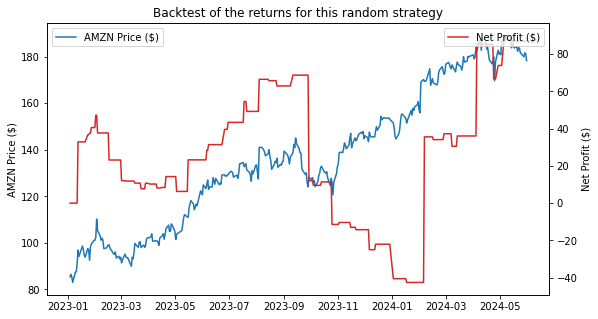

In [68]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9, 5))
ax1.set_ylabel(f"{stock_name_sample} Price ($)")
ax1.plot(results["Date"], results["Open"], color='tab:blue', label=f"{stock_name_sample} Price ($)")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel("Net Profit ($)")
ax2.plot(results["Date"], results["Net profit"], color='tab:red', label="Net Profit ($)")
ax2.legend(loc='upper right')

plt.title("Backtest of the returns for this random strategy")
plt.show()
